## Основные расчетные процедуры (ARPACK)

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import block_diag
import scipy.linalg as la

def boundary_layer_thickness(nu, u_e, x):
    return (nu*x/u_e)**0.5

def getRe_d(nu, u_e, d):
    return u_e*d/nu

def get_y(j, y):
    return y[j]

def get_U(j, vels):
    return vels[j]

def get_dudy(j, grads):
    return grads[j]

def get_h(y):
    return y[1] - y[0]

# Functions to form matrix A and B from Spatial Eigenvalues problem Ax = alpha*Bx
def getE1():
    return np.array([[0, 0, 0],
                     [1, 0, 0],
                     [0, 1, 0]])

def getE2(Re):
    return np.array([[0, 1, 0],
                     [0, 0, 0],
                     [0, 0,-Re]])

def getE3(omega, Re, dudy):
    return np.array([[0, 0, 0],
                     [1j*omega*Re, -Re*dudy, 0],
                     [0, 1j*omega*Re, 0]])

def getInvE4(omega, Re, u):
    return la.inv(np.array([[-1j, 0, 0],
                       [1j*Re*u, 0, 1j*Re],
                       [0, 1j*Re*u, 0]]))

def getA_matrix(omega, Re, N, mesh, vels, grads, comp_num = 3):
    h = get_h(mesh)
    matrix_list = list()
    
    # Form first line of matrix A
    line = list()
    y = get_y(1, mesh)
    u = get_U(1, vels)
    dudy = get_dudy(1, grads)
    invE4 = getInvE4(omega, Re, u)
    E1 = invE4@getE1()
    E2 = invE4@getE2(Re)
    E3 = invE4@getE3(omega, Re, dudy)
    L2 = E3 - 2./h**2*E1
    line.append(L2)
    L3 = 1./h**2*E1 + 1./(2*h)*E2
    line.append(L3)
    for i in range(3,N):
        line.append(np.zeros((comp_num,comp_num)))
    matrix_list.append(line)

    # Form inner lines of matrix A
    for i in range(2, N-1):
        line = list()
        y = get_y(i, mesh)
        u = get_U(i, vels)
        dudy = get_dudy(i, grads)
        invE4 = getInvE4(omega, Re, u)
        E1 = invE4@getE1()
        E2 = invE4@getE2(Re)
        E3 = invE4@getE3(omega, Re, dudy)
        for j in range(1, N):
            if j==i-1:
                L1 = 1./h**2*E1 - 1./(2*h)*E2
                line.append(L1)
            elif j==i:
                L2 = E3 - 2./h**2*E1
                line.append(L2)
            elif j==i+1:
                L3 = 1./h**2*E1 + 1./(2*h)*E2
                line.append(L3)
            else:
                line.append(np.zeros((comp_num,comp_num)))
        matrix_list.append(line)

    # Form last line of matrix A
    line = list()
    for i in range(1, N-2):
        line.append(np.zeros((comp_num,comp_num)))
    
    y = get_y(N-1, mesh)
    u = get_U(N-1, vels)
    dudy = get_dudy(N-1, grads)
    invE4 = getInvE4(omega, Re, u)
    E1 = invE4@getE1()
    E2 = invE4@getE2(Re)
    E3 = invE4@getE3(omega, Re, dudy)
    L1 = 1./h**2*E1 - 1./(2*h)*E2
    line.append(L1)
    L2 = E3 - 2./h**2*E1
    line.append(L2)
    matrix_list.append(line)

    return np.bmat(matrix_list)

## Профиль Блазиуса

Собственно все изменения надо сделать только здесь. В случае правильной реализации последний график со сперктром у вас совпадет с данными из статьи paper_data. Дополнительно проведите исследование как зависит решение от числа узлов сетки $N$. Опишите результат, приложите графики. Есть ли в спектре неустойчивые моды? Если да - укажите их.

In [26]:
import scipy.integrate as scii
import numpy as np

# свести к системы ОДУ первого порядка
def rhs(f, t):
    f1 = f[0]
    f2 = f[1]
    f3 = f[2]
    return np.array([f2, f3, -0.5 * f1 * f3])

#blasius profile
def getMesh_U_DuDy(N, y_max):
    x = np.linspace(0, y_max, N+1)
    y = scii.odeint(rhs, [0, 0, 1], x)

    k = y[-1, 1]
    alpha = (1. / k**1.5)**(1/3)
    x = x / alpha
    y[:, 0] *= alpha
    y[:, 1] *= alpha**2
    y[:, 2] *= alpha**3
    return x, y[:, 1], y[:,2]

# mesh
N = 500
# функция возвращает сетку, продольную скорость 
# и ее производную в погранслойных переменных (\eta) 
y_d, u_d, dudy_d = getMesh_U_DuDy(N, 15) 

## Постановка задачи в размерных переменных

In [27]:
mu = 1.85e-5
rho = 1.214
nu = mu/rho
u_e = 50
L = 3

omega_d = 0.26/1.72
Re_d = 1000/1.72
x = nu/u_e*Re_d**2
d = boundary_layer_thickness(nu, u_e, x)

omega = omega_d*(u_e/d)
Re = 1/nu

y = y_d*d
u = u_d*u_e
dudy = dudy_d*u_e/d

In [28]:
from scipy.sparse.linalg import eigs

A = getA_matrix(omega, Re, N, y, u, dudy)
eigvals, eigvec = eigs(A, 140, sigma=omega/u_e, which='LM')

#обезразмерим alpha
eigvals = eigvals*d

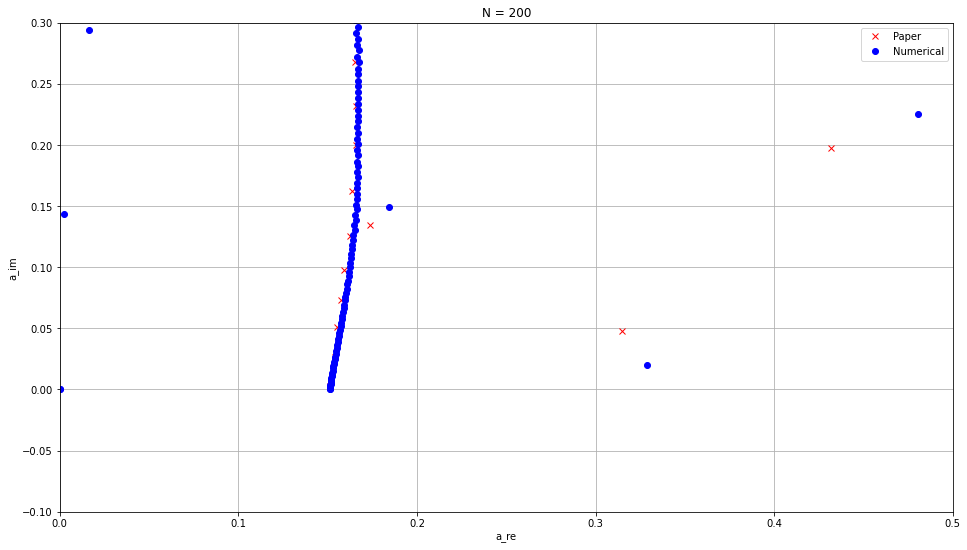

In [5]:
%matplotlib inline 
import matplotlib.pyplot as plt
import os

fig = plt.figure(figsize = (16, 9))
ax = fig.add_subplot(111)

paper_data = np.array([[0.2600153645394847,0.005216576864792044],
                       [0.2649509597575349,0.04520717573104338],
                       [0.267293525846102,0.08786938036706515],
                       [0.2709547061794915,0.12519574002357303],
                       [0.2732972722680586,0.1678579446595948],
                       [0.27947781613066175,0.2158461721950946],
                       [0.28170988381882467,0.27850858730426],
                       [0.28521636639164843,0.3438352416231689],
                       [0.28491433743054384,0.3985024835830948],
                       [0.28456810910927766,0.46116980973227817],
                       [0.28552576191277995,0.5211679856317001],
                       [0.29872663748105743,0.23180950777347475],
                       [0.5419115170904193,0.08201296514564738],
                       [0.7428786411853847,0.3402968372902284],
                       [0.28653498063647076,0.5718327299769883]])

paper_data /= 1.72

ax.plot(paper_data[:,0], paper_data[:,1], 'xr', label='Paper') # test case for omega = 0.26
ax.plot(eigvals.real, eigvals.imag, 'ob', label='Numerical')
plt.legend()
plt.xlim(0, 0.5)
plt.ylim(-0.1, 0.3)
# plt.xlim(0, 1)
# plt.ylim(0, 10)
plt.grid() 
plt.xlabel('a_re')
plt.ylabel('a_im')
plt.title("N = "+str(N))
os.chdir(os.getcwd() + "\outData")
plt.savefig("N = "+str(N) + ".jpg")
os.chdir(os.getcwd().replace("\outData", ""))

In [24]:
from PIL import Image

frames = []
N_array = np.array([10, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 800, 1000])

os.chdir(os.getcwd() + "\outData")

for frame_number in range(len(N_array)):
    # Открываем изображение каждого кадра.
    frame = Image.open(f'N = {N_array[frame_number]}.jpg')
    # Добавляем кадр в список с кадрами.
    frames.append(frame)
    
frames[0].save(
    'solution from N.gif',
    save_all=True,
    append_images=frames,  # Срез который игнорирует первый кадр.
    optimize=True,
    duration=100,
    loop=0
)

os.chdir(os.getcwd().replace("\outData", ""))

Таким образом, можно сделать два вывода:
1) Сходимость дискретной части спектра растет при увеличении числа узлов

2) Сходимость непрерывной части спектра имеет глобальный максимум при N = 200

In [29]:
if np.any((eigvals.imag < 0) * (eigvals.real < 0.5) * (eigvals.real > 0.001)) :
    print("Неустойчивые моды:" + str(eigvals[(eigvals.imag < 0) * (eigvals.real < 0.5) * (eigvals.real > 0.001)]))
else :
    print("Неустойчивые моды отсутствуют")

Неустойчивые моды отсутствуют
